# Решение задачи:

Установим необходимый ряд библиотек:

In [ ]:
!pip install openai llama-index-core "arize-phoenix[evals,llama-index]" gcsfs nest-asyncio "openinference-instrumentation-llama-index>=2.0.0"

  Using cached llama_index-0.11.0-py3-none-any.whl.metadata (11 kB)
  Using cached llama_index_cli-0.3.1-py3-none-any.whl.metadata (1.5 kB)
  Using cached llama_index_core-0.11.0.post1-py3-none-any.whl.metadata (2.4 kB)
  Using cached llama_index_embeddings_openai-0.2.5-py3-none-any.whl.metadata (686 bytes)
  Using cached llama_index_llms_openai-0.2.16-py3-none-any.whl.metadata (3.3 kB)
  Using cached llama_index_readers_file-0.2.2-py3-none-any.whl.metadata (5.4 kB)
INFO: pip is looking at multiple versions of llama-index-llms-openai to determine which version is compatible with other requirements. This could take a while.
  Using cached llama_index_llms_openai-0.2.15-py3-none-any.whl.metadata (3.3 kB)
  Using cached llama_index_llms_openai-0.2.14-py3-none-any.whl.metadata (3.3 kB)
  Using cached llama_index_llms_openai-0.2.13-py3-none-any.whl.metadata (3.3 kB)
  Using cached llama_index_llms_openai-0.2.12-py3-none-any.whl.metadata (649 bytes)
  Using cached llama_index_llms_openai-0.2

In [ ]:
!pip install llama_index --upgrade

  Using cached llama_index-0.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached llama_index_cli-0.5.0-py3-none-any.whl.metadata (1.4 kB)
  Using cached llama_index_core-0.13.1-py3-none-any.whl.metadata (2.5 kB)
  Using cached llama_index_embeddings_openai-0.5.0-py3-none-any.whl.metadata (400 bytes)
  Using cached llama_index_indices_managed_llama_cloud-0.9.1-py3-none-any.whl.metadata (3.5 kB)
  Using cached llama_index_llms_openai-0.5.3-py3-none-any.whl.metadata (3.0 kB)
  Using cached llama_index_readers_file-0.5.0-py3-none-any.whl.metadata (5.3 kB)
  Using cached llama_index_readers_llama_parse-0.5.0-py3-none-any.whl.metadata (3.1 kB)
  Using cached llama_cloud-0.1.35-py3-none-any.whl.metadata (1.2 kB)
  Using cached pypdf-5.9.0-py3-none-any.whl.metadata (7.1 kB)
INFO: pip is looking at multiple versions of llama-cloud-services to determine which version is compatible with other requirements. This could take a while.
  Using cached llama_cloud_services-0.6.57-py3-none-any.whl.meta

Установим **Cloudflared** для создания защищенных туннелей. `chmod +x` Делает файл **cloudflared** исполняемым (разрешает запускать его как программу).

In [ ]:
!wget -q https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64 -O cloudflared
!chmod +x cloudflared

Реализуем код для ввода API-ключа. Так как я пользуюсь сервисом **VseGPT**, то настройка будет отличаться от стандартной. Мне необходимо задействовать **base_url**, что является особенностью использования API у этого сервиса:

In [ ]:
import getpass
import os
import nest_asyncio
import threading
import time


os.environ["OPENAI_API_KEY"] = getpass.getpass("Введите VseGPT API Key:")
api_key = os.environ["OPENAI_API_KEY"]

VSEGPT_API_BASE = "https://api.vsegpt.ru/v1" #будем использовать для base_url

Введите VseGPT API Key:··········


Скачаем книгу с **Google Диска** в папку **/content**:

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1cTR1Q4DeJFkqVHy069yU_BJ5anuggehP' -O /content/book.pdf

--2025-08-12 18:48:40--  https://docs.google.com/uc?export=download&id=1cTR1Q4DeJFkqVHy069yU_BJ5anuggehP
Resolving docs.google.com (docs.google.com)... 142.251.189.138, 142.251.189.101, 142.251.189.102, ...
Connecting to docs.google.com (docs.google.com)|142.251.189.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1cTR1Q4DeJFkqVHy069yU_BJ5anuggehP&export=download [following]
--2025-08-12 18:48:40--  https://drive.usercontent.google.com/download?id=1cTR1Q4DeJFkqVHy069yU_BJ5anuggehP&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 173.194.193.132, 2607:f8b0:4001:c0f::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|173.194.193.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 349153 (341K) [application/octet-stream]
Saving to: ‘/content/book.pdf’

/content/book.pdf   100%[===================>] 340.97K  --.-K

Импортируем необходимые библиотеки:


In [ ]:
import openai
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core import (
    GPTVectorStoreIndex,
    SimpleDirectoryReader,
    Settings
)
import phoenix as px
from openinference.instrumentation.llama_index import LlamaIndexInstrumentor
from opentelemetry.exporter.otlp.proto.http.trace_exporter import OTLPSpanExporter
from opentelemetry.sdk.trace import TracerProvider
from opentelemetry.sdk.trace.export import SimpleSpanProcessor

from llama_index.core.llama_pack import download_llama_pack

В качестве расширенного поисковика на **Llama Hub** будем использоваться данный **Llama Pack**, а именно: **FuzzyCitationEnginePack**. Для этого установим его:

In [ ]:
FuzzyCitationEnginePack = download_llama_pack(
    "FuzzyCitationEnginePack", "./fuzzy_citation_pack"
)

Загрузим нашу книгу из каталога:

In [ ]:
documents = SimpleDirectoryReader('/content').load_data()

**Phoenix** использует **asyncio**, поэтому нам необходимо выполнить слепдующую команду, чтобы избежать ошибку:

In [ ]:
nest_asyncio.apply() #необходим для параллельных вычислений в среде ноутбуков

Запустим **Phoenix** в фоновом режиме для сбора данных трассировки:

In [ ]:
session = px.launch_app()

/usr/lib/python3.11/contextlib.py:144: SAWarning: Skipped unsupported reflection of expression-based index ix_cumulative_llm_token_count_total
  next(self.gen)
/usr/lib/python3.11/contextlib.py:144: SAWarning: Skipped unsupported reflection of expression-based index ix_latency
  next(self.gen)


🌍 To view the Phoenix app in your browser, visit https://9wifzirnm11-496ff2e9c6d22116-6006-colab.googleusercontent.com/
📖 For more information on how to use Phoenix, check out https://arize.com/docs/phoenix


Напишем функцию, которая производит запуск **Cloudflared** туннеля.

Внутри функции с помощью subprocess.Popen запускается команда .`/cloudflared tunnel --url http://localhost:6006`. Эта команда создаёт защищённый публичный туннель к локальному веб-серверу **Phoenix UI**, который работает на порту 6006.

Когда появляется строка с публичным адресом (он содержит "trycloudflare.com" — например, https://randomstring.trycloudflare.com), с помощью регулярного выражения извлекается URL. Этот URL выводится в консоль — по нему можно открыть Phoenix UI из любого браузера.

In [ ]:
#запуск Cloudflared туннеля
def start_cloudflared():
    import subprocess, re
    proc = subprocess.Popen(
        ['./cloudflared', 'tunnel', '--url', 'http://localhost:6006'],
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        universal_newlines=True,
    )
    for line in proc.stdout:
        if "trycloudflare.com" in line:
            urls = re.findall(r'https?://[^\s]+', line)
            if urls:
                print("\n🌐 Phoenix UI доступен по публичной ссылке:", urls[0])
                break


threading.Thread(target=start_cloudflared, daemon=True).start() #запускаем функцию в отдельном фоне потока, чтобы основной код не блокировался

Настройка трассировки (Tracing) для Phoenix и LlamaIndex:

In [ ]:
endpoint = "http://127.0.0.1:6006/v1/traces" #указываем адрес эндпоинта, куда будут отправляться трассировки

tracer_provider = TracerProvider() #создаём провайдер трассировки

tracer_provider.add_span_processor(SimpleSpanProcessor(OTLPSpanExporter(endpoint))) #добавляем обработчик спанов — SimpleSpanProcessor

#инструментируем LlamaIndex, чтобы автоматически трассировать все его операции
LlamaIndexInstrumentor().instrument(
    skip_dep_check=True, #отключает проверку зависимостей
    tracer_provider=tracer_provider
)

Далее выполним необходимую настройку для работы моего *API-ключа* от **VseGPT**:

In [ ]:
openai.api_key = api_key
openai.base_url = VSEGPT_API_BASE

Выполним настройку эмбеддинга и LLM:

In [ ]:
Settings.llm = OpenAI(
    openai_api_key=api_key,
    model="gpt-4o",
    base_url=VSEGPT_API_BASE
)
Settings.embed_model = OpenAIEmbedding(
    openai_api_key=api_key,
    model="text-embedding-ada-002",
    base_url=VSEGPT_API_BASE
)


🌐 Phoenix UI доступен по публичной ссылке: https://keyboard-spare-pipeline-creature.trycloudflare.com


Инициализация индекса и движка запросов:

In [ ]:
index = GPTVectorStoreIndex.from_documents(documents) #создание векторного индекса по нашему документу
query_engine = index.as_query_engine() #создаем движок запросов

Используем **Fuzzy Citation Query Engine** - один из **Llama Pack**, который был выбран в рамках решения этой задачи:

In [ ]:
fuzzy_engine = FuzzyCitationEnginePack(query_engine, threshold=50) #threshold=50 - порог схожести

Напишем промпты и получим ответы на них:


In [ ]:
response_1 = fuzzy_engine.run("You know a lot about literature. Tell me where the old man lived - one of the main characters of the book. The answer should be based only on information from the book, do not invent anything. The answer should be clear and concise.")
response_2 = fuzzy_engine.run("You know a lot about literature. Tell me Who did the old man catch in the book? The answer should be based only on information from the book, do not invent anything. The answer should be clear and concise.")

print("\nОтвет 1:", response_1)
print("Ответ 2:", response_2)


Ответ 1: The old man lived by the edge of the blue sea.
Ответ 2: The old man caught a golden fish that could speak with a human voice.


# Выводы по трассировке:


После получения сгенерированной ссылки можно перейти в раздел **Traces** и проанализировать данные, которые подаются в LLM. Рассмотрим один из промптов, в котором мы наблюдаем то, как и какие данные подаются на вход (**Input**). На выходе (**Output**) мы получаем ответ от нашей системы в виде основного ответа (**response**), узлов-источников (**source-nodes**) и словаря с дополнительной информацией о запросе или ответе (**metadata**).

**source nodes** — список текстовых сегментов книги, которые использовались для получения ответа.

Каждый элемент:
* **TextNode** — объект, содержащий исходный текст (фрагмент книги);
* **id_** — уникальный идентификатор этого фрагмента;
* **score** — числовая оценка релевантности этого узла к запросу (0.0 = нерелевантно, 1.0 = максимально релевантно).

Такой формат позволяет обосновывать ответы: почему система ответила именно так, и на какой кусок книги она опиралась.

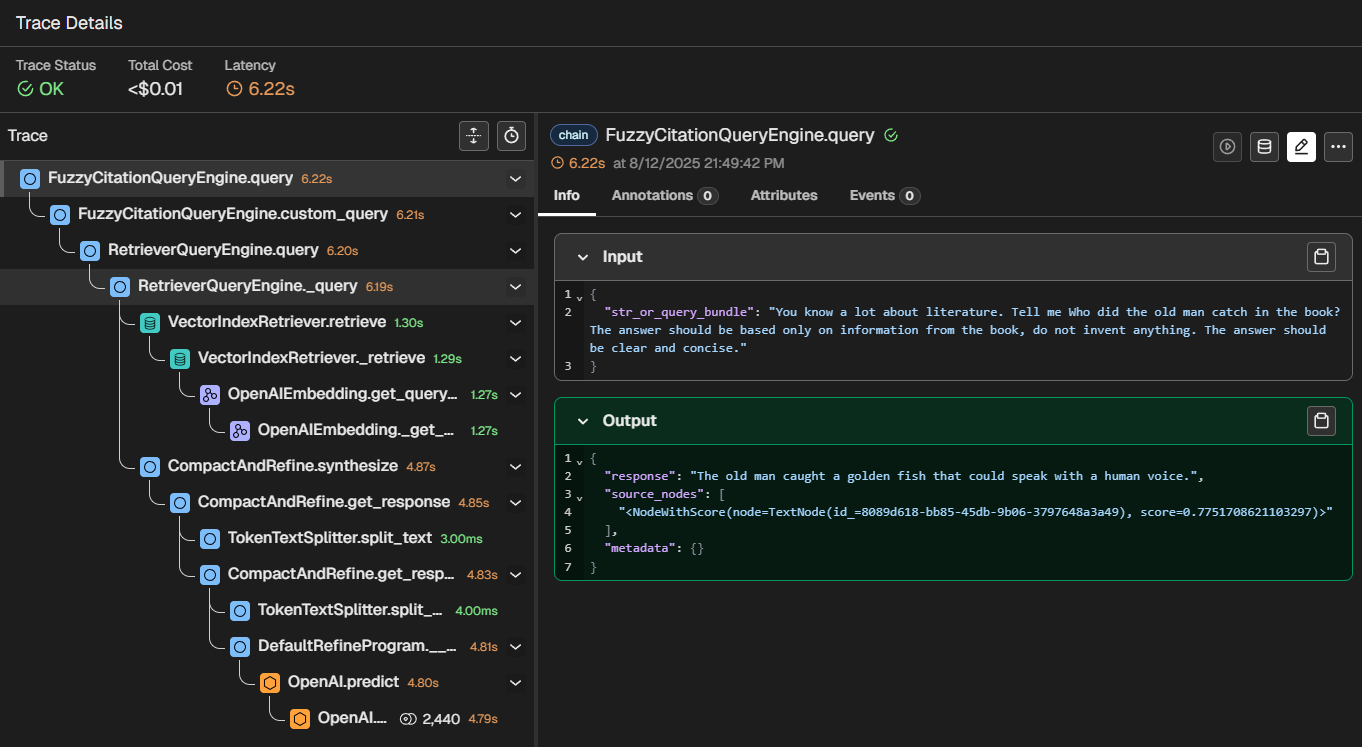

**Итог:**  На 1 и 2 промпт был получен отличный ответ, система сработала корректно, галлюцинации не наблюдаются.